In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Covariance function as prior
To sample functions from the Gaussian process we need to define the mean and covariance functions $K(X_a,x_b)$. The covariance function models the joint variability of the Gaussian process random variables. It returns the modelled covariance between each pair in and the specification of this covariance function, also known as the kernel function, implies a distribution over functions . By choosing a specific kernel function  it is possible to set prior information on this distribution. This kernel function needs to be positive-definite in order to be a valid covariance function 
                               $ K(x_a,x_b)=exp(-\frac{1}{2\sigma^2}||x_a-x_b||^2)$.

 In this post we will model the covariance with the exponentiated quadratic covariance function (also known as the RBF kernel):

 


In [2]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Sampling from prior
In practice we can't just sample a full function evaluation  from a Gaussian process distribution since that would mean evaluating $m(x)$ and $K(X,X^\prime)$
 at an infinite number of points since  can have an infinite domain . We can however sample function evaluations  of a function  drawn from a Gaussian process at a finite, but arbitrary, set of points$X:y=f(X)$.

A finite dimensional subset of the Gaussian process distribution results in a multivariate Gaussian distribution $y\sim N(\mu,\Sigma)$ with mean vector$\mu=m(X)$ , covariance matrix$ \Sigma=k(X,X)$ .

In the figure below we will sample 5 different function realisations from a Gaussian process with exponentiated quadratic prior without any observed data. We do this by drawing correlated samples from a 41-dimensional Gaussian $N(0,k(X,X))$ with $X=[X_1...X_{41}]$


In [3]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

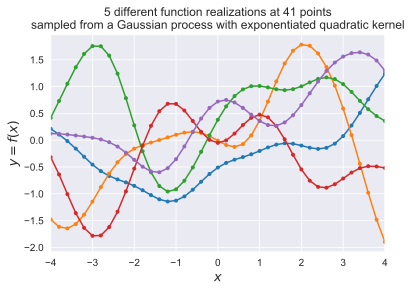

In [8]:
# Plot the sampled functions
%config InlineBackend.figure_format = 'svg'
sns.set_style('darkgrid')
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()
#


# Gaussian processes for regression
Since Gaussian processes model distributions over functions we can use them to build regression models. We can treat the Gaussian process as a prior defined by the kernel function and create a posterior distribution given some data. This posterior distribution can then be used to predict the expected value and probability of the output variable Y given input variables X.

# Predictions from posterior
We want to make predictions $y=f(X_2)$
 for $n_2$ new samples, and we want to make these predictions based on our Gaussian process prior and $n_1$
 previously observed data points $(X_1,y_1)$
. This can be done with the help of the posterior distribution $p(y_2|y_1,X_1,X_2)$
. Keep in mind that 
 and 
 are jointly Gaussian since they both come from the same multivariate distribution. Since they are jointly Gaussian and we have a finite number of samples we can write:
 $ \begin{bmatrix} y_1 \\ y_2\end{bmatrix} \sim N\left(\begin{bmatrix}\mu_1 \\ \mu_2\end{bmatrix},\begin{bmatrix}\Sigma_{11}& \Sigma_{12} \\ \Sigma_{21}&\Sigma_{22}\end{bmatrix}\right) $
 
 We can then get the conditional distribution:
 
 ### $p(y_2|y_1,X_1,X_2)=N(\mu_{2|1},\Sigma_{2|1})$
 Where,
 ### $\mu_{2|1} = (\Sigma_{11}^{-1}\Sigma_{12})^Ty_1$,
 ### $ \Sigma_{2|1}=\Sigma_{22}-(\Sigma_{11}^{-1}\Sigma_{12})^T\Sigma_{12}$

In [9]:
# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    
    return μ2, Σ2  # mean, covariance

In [10]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)
# Plot the postior distribution and some samples

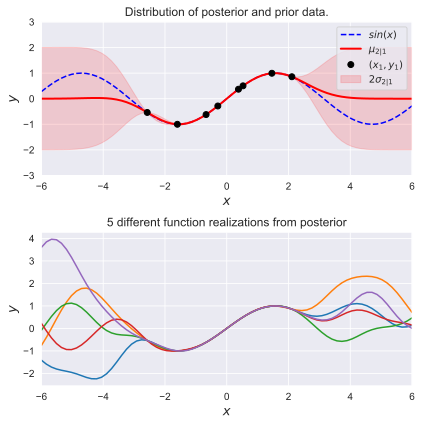

In [11]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#


# Noisy observations
The predictions made above assume that the observations come from a noiseless distribution. We can notice this in the plot above because the posterior variance becomes zero at the observations 
. We can make predictions from noisy observations $ f(X_1)=y_1+\epsilon$ by modelling the noise  as Gaussian noise with variance $\sigma_{\epsilon}^2 $

This noise can be modelled by adding it to the covariance kernel of our observations:

$\Sigma_{11}= k(X_1,X_1)+\sigma_{\epsilon}^2I$
.

In [12]:
def GP_noise(X1, y1, X2, kernel_func, σ_noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((σ_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [13]:
# Compute the posterior mean and covariance

σ_noise = 1.  # The standard deviation of the noise
# Add noise kernel to the samples we sampled previously
y1 = y1 + ((σ_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, σ_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

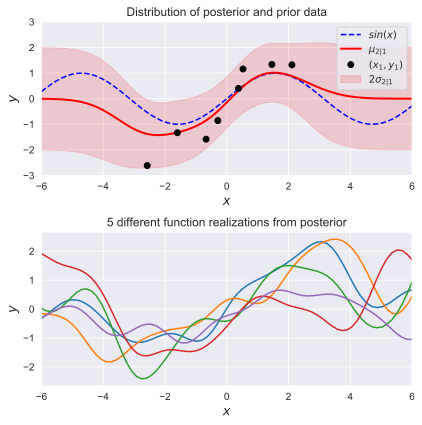

In [14]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#